# Bicycle Details from the Census Bureau

In [45]:
# Install required packages
!pip install requests pandas seaborn matplotlib altair

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.8/857.8 kB 24.5 MB/s eta 0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.5 MB/s eta 0:00:00


## API Key

The Census bureau API requires an API key
You can obtain one at https://api.census.gov/data/key_signup.html

In [1]:
api_key = 'get_your_own_key'

## Main Method

The following method calls an endpoint for data about commuting.

In [15]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt

uri_base = 'http://api.census.gov/data/'
uri_data = '/acs/acs1?get=NAME,B01001_001E,B08006_014E,B08006_001E&for=county:099&in=state:12&key='  


def commute_by_year(yr):
    """
    Fetches commute data for a specific year from an API.

    Parameters:
    - yr (int): The year for which to fetch the commute data.

    Returns:
    - dict: A dictionary containing the commute data for the specified year, 
    where the keys are the headers and the values are the corresponding values.

    """
    r = requests.get(uri_base+str(yr)+uri_data+api_key)
    if r.status_code == 200: # 200 means success
        try:
            data = json.loads(r.text)
            headers = data[0]
            values = data[1]
            return dict(zip(headers, values))
        except json.JSONDecodeError: # If the response is not JSON
            print(f"Error decoding JSON for year {yr}")
            return None
    else:
        # Only print a log if you're working with small amounts of data
        print(f"Error fetching data for year {yr}. Status code: {r.status_code}")
        return None

# Sample call to test the function
commute_by_year(2022)

{'NAME': 'Palm Beach County, Florida',
 'B01001_001E': '1518477',
 'B08006_014E': '3421',
 'B08006_001E': '707799',
 'state': '12',
 'county': '099'}

In [32]:
# Generate a list of years
years = [year for year in range(2022, 2009, -1)]
years

[2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010]

In [37]:
# Fetch commute data for each year into a list
data_list = [commute_by_year(year) for year in years if commute_by_year(year) is not None]

# Convert the list of dictionaries into a Pandas DataFrame
df_bike = pd.DataFrame(data_list)

In [33]:
# Remove any years that didn't work
#years.remove(2020) 

In [38]:
df_bike['Year'] = years

# Generate new fields for bike mode share 
df_bike['mode_share'] = df_bike['B08006_014E'].astype(float)/df_bike['B08006_001E'].astype(float)
df_bike['share_commute'] = df_bike['B08006_001E'].astype(float)/df_bike['B01001_001E'].astype(float)

df_bike.set_index(df_bike['Year'], inplace=True)
df_bike.sort_index(inplace=True)

df_bike

,NAME,B01001_001E,B08006_014E,B08006_001E,state,county,Year,mode_share,share_commute
Year,,,,,,,,,
2010,"Palm Beach County, Florida",1323394,2843,564880,12,099,2010,0.005033,0.426842
2011,"Palm Beach County, Florida",1335187,2055,559574,12,099,2011,0.003672,0.419098
2012,"Palm Beach County, Florida",1356545,3330,587191,12,099,2012,0.005671,0.432858
2013,"Palm Beach County, Florida",1372171,3303,607680,12,099,2013,0.005435,0.442860
2014,"Palm Beach County, Florida",1397710,5105,630241,12,099,2014,0.008100,0.450910
2015,"Palm Beach County, Florida",1422789,6066,643595,12,099,2015,0.009425,0.452347
2016,"Palm Beach County, Florida",1443810,4035,656745,12,099,2016,0.006144,0.454869
2017,"Palm Beach County, Florida",1471150,1900,668624,12,099,2017,0.002842,0.454491
2018,"Palm Beach County, Florida",1485941,7594,678427,12,099,2018,0.011194,0.456564


## Plots

### Matplotlib

/tmp/ipykernel_29779/223688779.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])


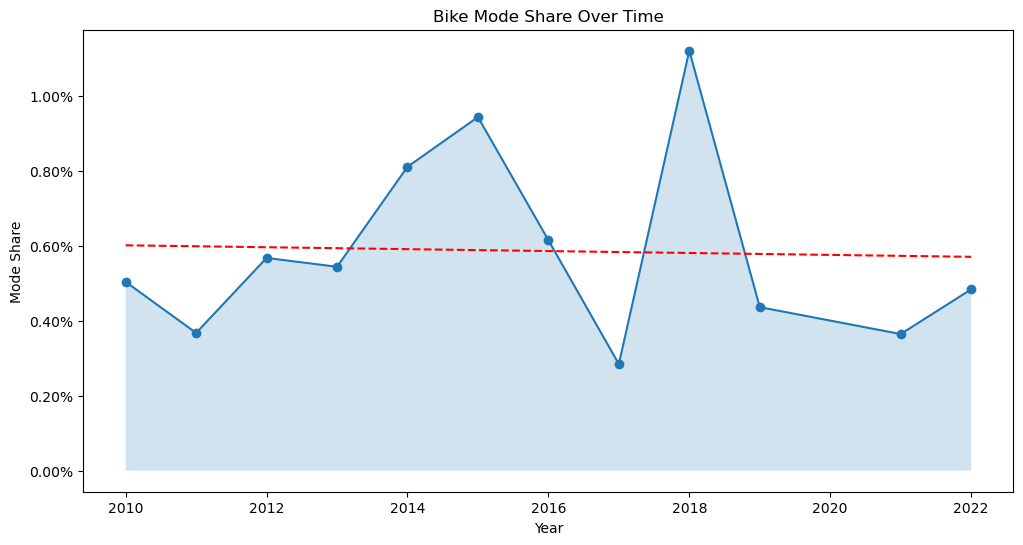

In [42]:
import numpy as np
%matplotlib inline  

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df_bike['Year'], df_bike['mode_share'], marker='o')
ax.fill_between(df_bike['Year'], df_bike['mode_share'], alpha=0.2)

z = np.polyfit(df_bike['Year'], df_bike['mode_share'], 1)
p = np.poly1d(z)
ax.plot(df_bike['Year'], p(df_bike['Year']), "r--")

ax.set_xlabel('Year')
ax.set_ylabel('Mode Share')
ax.set_title('Bike Mode Share Over Time')

vals = ax.get_yticks()
ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])

plt.show()

### Altair

Altair is a nice alternative. It's derived from Vega, which is a really good javascript library

A bonus is that you can save the output as svg and even modify the vega script in an online editor.

In [48]:
import altair as alt

chart = alt.Chart(df_bike).mark_line(point=True).encode(
    x='Year',
    y=alt.Y('mode_share', axis=alt.Axis(format='%')),
    tooltip=['Year', 'mode_share']
).properties(
    width=800,
    height=400,
    title='Bike Mode Share Over Time'
)

trend = chart.transform_regression('Year', 'mode_share').mark_line(color='red', strokeDash=[5, 5])

(chart + trend).interactive()

alt.LayerChart(...)